In [1]:
import polars as pl
import numpy as np
import pyarrow as pa

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from polars_tools import down_cast_numeric_cols

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV

from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

In [2]:
"""
Notes

Classifier models to investigate:
- Logistic Regression
- K-nearest neighbours
- naive bayes
- support vector
- Decision Tree
- Random Forest (isn't this enemble?)
- Some interpretable ensemble (there is one in my notes)
"""

"\nNotes\n\nClassifier models to investigate:\n- Logistic Regression\n- K-nearest neighbours\n- naive bayes\n- support vector\n- Decision Tree\n- Random Forest (isn't this enemble?)\n- Some interpretable ensemble (there is one in my notes)\n"

In [3]:
lf = pl.scan_csv(r"data.csv")

In [4]:
lf = lf.collect().drop(pl.col("")).lazy()

# Data Exploration

## Basics (Epxloration)

In [5]:
lf.collect().shape

(569, 32)

In [6]:
lf.describe()

statistic,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",569.0,"""569""",569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.0372e7,null,14.127292,19.289649,91.969033,654.889104,0.09636,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.26919,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
"""std""",1.2502e8,null,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.07972,0.038803,0.027414,0.00706,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.00617,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
"""min""",8670.0,"""B""",6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,0.04996,0.1115,0.3602,0.757,6.802,0.001713,0.002252,0.0,0.0,0.007882,0.0008948,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504
"""25%""",869218.0,null,11.7,16.17,75.17,420.3,0.08637,0.06492,0.02956,0.02031,0.1619,0.0577,0.2324,0.8339,1.606,17.85,0.005169,0.01308,0.01509,0.007638,0.01516,0.002248,13.01,21.08,84.11,515.3,0.1166,0.1472,0.1145,0.06493,0.2504,0.07146
"""50%""",906024.0,null,13.37,18.84,86.24,551.1,0.09587,0.09263,0.06154,0.0335,0.1792,0.06154,0.3242,1.108,2.287,24.53,0.00638,0.02045,0.02589,0.01093,0.01873,0.003187,14.97,25.41,97.66,686.5,0.1313,0.2119,0.2267,0.09993,0.2822,0.08004
"""75%""",8.813129e6,null,15.78,21.8,104.1,782.7,0.1053,0.1304,0.1307,0.074,0.1957,0.06612,0.4789,1.474,3.357,45.19,0.008146,0.03245,0.04205,0.01471,0.02348,0.004558,18.79,29.72,125.4,1084.0,0.146,0.3391,0.3829,0.1614,0.3179,0.09208
"""max""",9.11320502e8,"""M""",28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,0.2012,0.304,0.09744,2.873,4.885,21.98,542.2,0.03113,0.1354,0.396,0.05279,0.07895,0.02984,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075


In [7]:
lf.schema

C:\Users\Jan\AppData\Local\Temp\ipykernel_24256\2177650233.py:1: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  lf.schema


Schema([('id', Int64),
        ('diagnosis', String),
        ('radius_mean', Float64),
        ('texture_mean', Float64),
        ('perimeter_mean', Float64),
        ('area_mean', Float64),
        ('smoothness_mean', Float64),
        ('compactness_mean', Float64),
        ('concavity_mean', Float64),
        ('concave points_mean', Float64),
        ('symmetry_mean', Float64),
        ('fractal_dimension_mean', Float64),
        ('radius_se', Float64),
        ('texture_se', Float64),
        ('perimeter_se', Float64),
        ('area_se', Float64),
        ('smoothness_se', Float64),
        ('compactness_se', Float64),
        ('concavity_se', Float64),
        ('concave points_se', Float64),
        ('symmetry_se', Float64),
        ('fractal_dimension_se', Float64),
        ('radius_worst', Float64),
        ('texture_worst', Float64),
        ('perimeter_worst', Float64),
        ('area_worst', Float64),
        ('smoothness_worst', Float64),
        ('compactness_worst', Float

## Show correlation matrix Heatmap

In [8]:
## re-lable the diagnosis
lf = lf.with_columns(
    (pl.when(pl.col("diagnosis")==pl.lit('B')).then(1).otherwise(0)).alias("diagnosis")
               )

In [9]:
lf.collect()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
842302,0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,0,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,0,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,0,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
926424,0,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623,1.176,1.256,7.673,158.7,0.0103,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
926682,0,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.0395,0.01678,0.01898,0.002498,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
926954,0,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.0473,0.01557,0.01318,0.003892,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782


In [10]:
lf_no_id = lf.select(
    pl.exclude(["id"])
).collect()

In [11]:
transformer = StandardScaler().fit(lf_no_id)
transformer

StandardScaler()

In [12]:
trans_arr = transformer.transform(lf_no_id)
#lf_scaled = pl.concat([lf.select(pl.col("diagnosis")) ,  pl.LazyFrame(trans_arr , schema=df.columns)] ,how="horizontal")
lf_scaled = pl.LazyFrame(trans_arr , schema=lf_no_id.columns)

df = lf_scaled.collect()

In [13]:
pl.concat([lf.select(pl.col("id")),lf_scaled] , how="horizontal").collect()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
842302,-1.297676,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.66082,1.148757,0.907083,1.88669,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
842517,-1.297676,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.44078,0.260162,-0.80545,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.24389,0.28119
84300903,-1.297676,1.579888,0.456187,1.566503,1.558884,0.94221,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.51187,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955,1.152255,0.201391
84348301,-1.297676,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.74428,0.819518,1.115007,4.73268,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.93501
84358402,-1.297676,1.750297,-1.151816,1.776573,1.826229,0.280372,0.53934,1.371011,1.428493,-0.00956,-0.56245,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.04852,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.46677,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.3971
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
926424,-1.297676,2.110995,0.721473,2.060786,2.343856,1.041842,0.21906,1.947285,2.320965,-0.312589,-0.931027,2.78208,0.071025,2.379583,2.604187,1.086384,0.191805,0.666001,2.067178,-1.138416,0.16798,1.901185,0.1177,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
926682,-1.297676,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,1.300499,2.260938,1.156857,1.291565,-0.42401,-0.069758,0.252202,0.808431,-0.189161,-0.490556,1.53672,2.047399,1.42194,1.494959,-0.69123,-0.39482,0.236573,0.733827,-0.531855,-0.973978
926954,-1.297676,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.03868,0.046588,0.105777,-0.809117,-0.895587,0.184892,-0.257371,0.276693,0.180698,-0.379342,0.661277,0.510827,0.612157,-0.891416,0.036727,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409


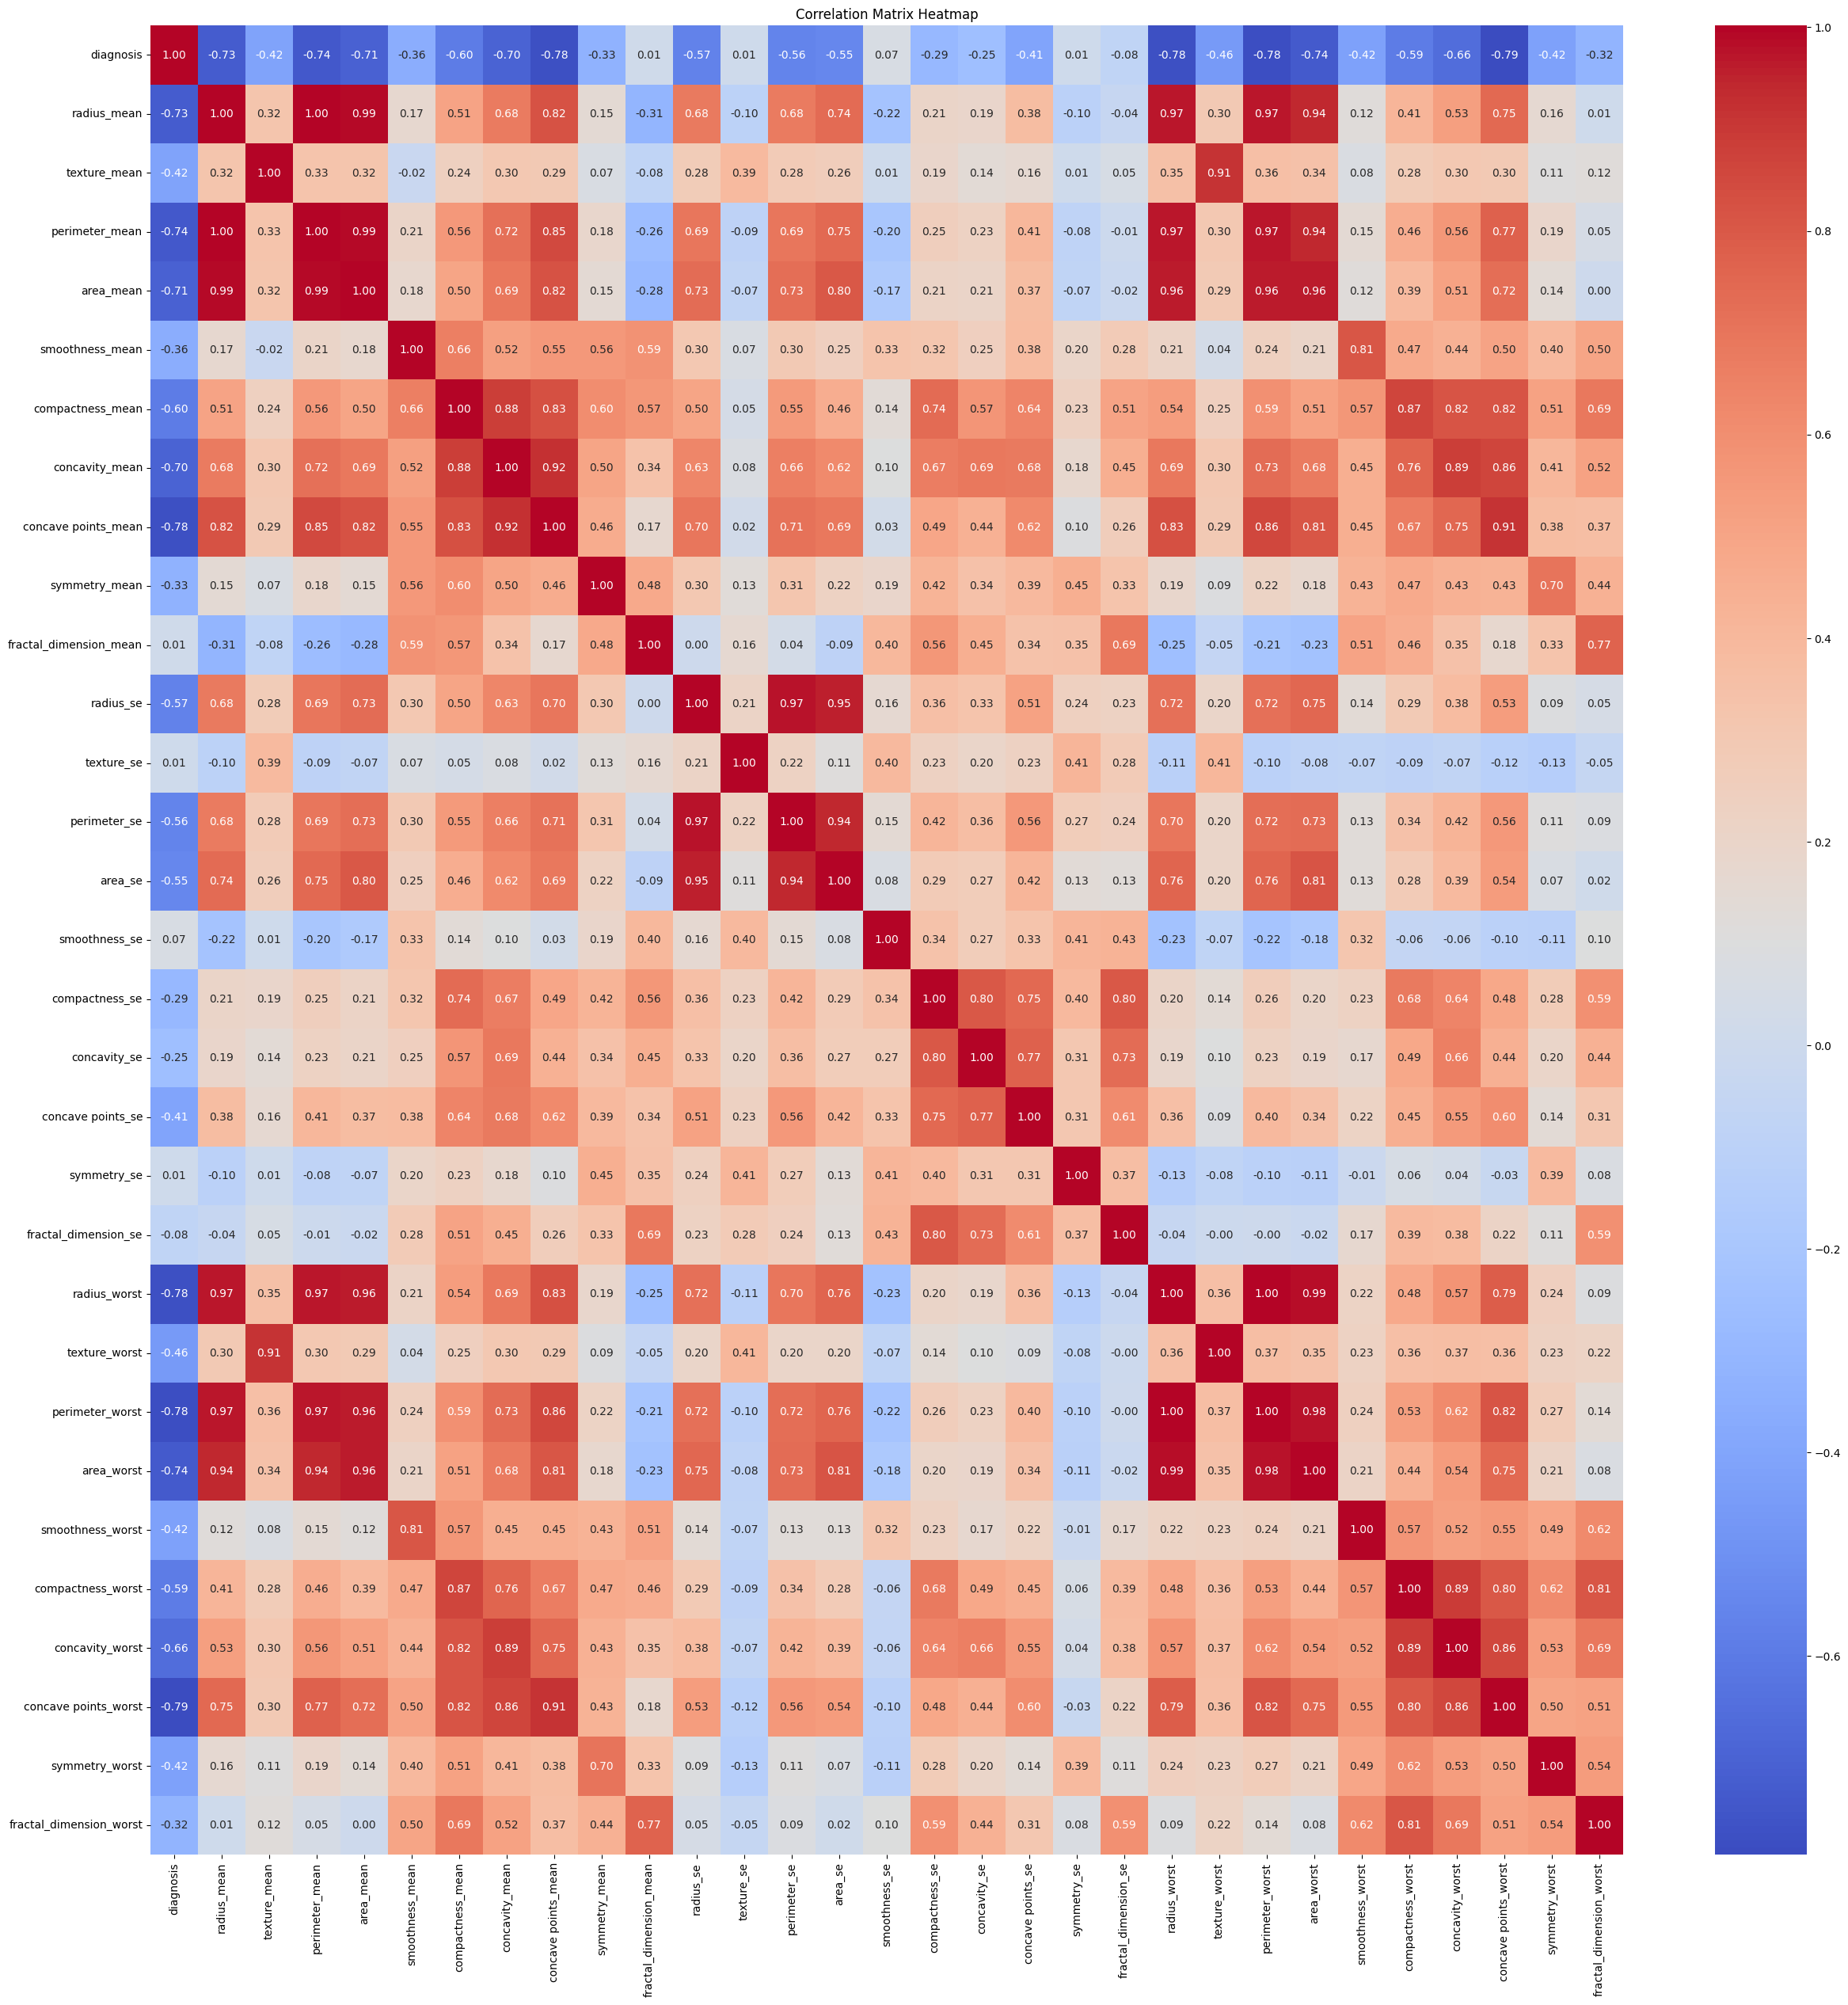

In [14]:
## Encoding:
# Malignant: -1.297676
# Benign: 0.770609


# Findings: -Drop all features with less than 0.4 or -0.4 correlation.
#           -Look at Multicolllinearity --> for those features that have high correlation with the target variable, check if they have high correlation with each other and then drop one of them
df = lf_scaled.collect()

# Correlation Matrix created by calculating covariance. This is possible because the dataset is standardized
#covariance_matrix_unscaled = np.cov(df, rowvar=False)
covariance_matrix = np.cov(df, rowvar=False) 

# Visualize the Covariance Matrix
plt.figure(figsize=(30, 30))
#, dpi=120
ax = sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True , xticklabels=df.columns , yticklabels=df.columns)

# Add labels and title
plt.title("Correlation Matrix Heatmap")
plt.show()

## Pairplot

# Prepare Train-Test Data

### Create train-test split

In [15]:
# Combine df again
df = pl.concat([ lf.select(pl.col("diagnosis")).collect() , df.select(pl.exclude(["diagnosis"]))] , how="horizontal")

In [16]:
# Split target out
X = df.select(
    pl.exclude(["diagnosis"])
)
y = df.select(pl.col("diagnosis"))


# Save feature names
feature_names = X.columns

# Create train/test-split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.33, random_state=42)

# Convert Dataframes to Numpy Array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Create reduced train-test split (based on correlation)

In [17]:
# these are the ones with correlation > 0.4 and <-0.4
df_reduced = df.select(
    pl.col("diagnosis"),
    pl.col("radius_mean"),
    pl.col("texture_mean"),
    pl.col("perimeter_mean"),
    pl.col("area_mean"),
    pl.col("compactness_mean"),
    pl.col("concavity_mean"),
    pl.col("concave points_mean"),
    pl.col("radius_se"),
    pl.col("perimeter_se"),
    pl.col("area_se"),
    pl.col("concave points_se"),
    pl.col("radius_worst"),
    pl.col("texture_worst"),
    pl.col("perimeter_worst"),
    pl.col("area_worst"),
    pl.col("smoothness_worst"),
    pl.col("compactness_worst"),
    pl.col("concavity_worst"),
    pl.col("concave points_worst"),
    pl.col("symmetry_worst"),
    pl.col("fractal_dimension_worst"),
)

### Create reduced train-test split (based on multi-colinearity)

In [18]:
df_reduced_multi_col = df.select(
    pl.col("diagnosis"),
    pl.col("texture_mean"),
    pl.col("compactness_mean"),
    pl.col("concavity_mean"),
    pl.col("concave points_mean"),
    pl.col("radius_se"),
    pl.col("concave points_se"),
    pl.col("radius_worst"),
    pl.col("texture_worst"),
    pl.col("perimeter_worst"),
    pl.col("smoothness_worst"),
    pl.col("compactness_worst"),
    pl.col("concavity_worst"),
    pl.col("concave points_worst"),
    pl.col("symmetry_worst"),
    pl.col("fractal_dimension_worst"),
)

# Create Baseline Models

### K-Nearest Neighbor

In [19]:
# Initialize Classifier wiht k=3 neighbors
neigh = KNeighborsClassifier(n_neighbors=3)
    
# Train the model
neigh.fit(X_train, y_train)
    
# Make predictions
y_pred = neigh.predict(X_test)
    
# Calculate accuracy score based on output predictions
knn_accuracy = accuracy_score(y_test, y_pred)
print("K-Nearest Neighbor basline accuracy is: " , knn_accuracy)


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_perm_importance = permutation_importance(neigh, X_test, y_test, scoring="accuracy")
knn_importances = knn_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": knn_importances})
knn_feature_importance_list = knn_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbor basline accuracy is:  0.9574468085106383
Feature importance:  [('texture_worst', 0.01595744680851068), ('radius_worst', 0.01489361702127665), ('texture_se', 0.011702127659574502), ('smoothness_worst', 0.011702127659574502), ('concavity_mean', 0.008510638297872375)]


### Naive Bayes

In [20]:
# Initialize the Gaussian Naives Bayes
gnb = GaussianNB()

# Train the model
gnb.fit(X_train , y_train)

# Make prediction
y_pred = gnb.predict(X_test)

# Calculate accuracy score based on output predictions
gnb_accuracy = accuracy_score(y_test, y_pred)
print("K-Nearest Neighbor basline accuracy is: " , gnb_accuracy)

# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_perm_importance = permutation_importance(gnb, X_test, y_test, scoring="accuracy")
gnb_importances = gnb_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": gnb_importances})
gnb_feature_importance_list = gnb_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_feature_importance_list)

K-Nearest Neighbor basline accuracy is:  0.9361702127659575


C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature importance:  [('area_se', 0.06382978723404256), ('area_worst', 0.0468085106382979), ('perimeter_se', 0.01914893617021283), ('concave points_mean', 0.019148936170212804), ('radius_se', 0.017021276595744726)]


### Support Vector Machines

In [21]:
# Initialize the Support vector machine
clf = svm.SVC()

# Train the model
clf.fit(X_train , y_train)

# Make prediction
y_pred = clf.predict(X_test)

# Calculate accuracy score based on output predictions
svm_accuracy = accuracy_score(y_test, y_pred)
print("K-Nearest Neighbor basline accuracy is: " , svm_accuracy)

# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_perm_importance = permutation_importance(clf, X_test, y_test, scoring="accuracy")
svm_importances = svm_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": svm_importances})
svm_feature_importance_list = svm_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_feature_importance_list)

K-Nearest Neighbor basline accuracy is:  0.9680851063829787


C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature importance:  [('texture_worst', 0.007446808510638303), ('fractal_dimension_mean', 0.007446808510638303), ('concavity_se', 0.004255319148936199), ('texture_se', 0.0031914893617021487), ('symmetry_se', 0.0010638297872340497)]


### Decision Tree

In [22]:
# Initialize the Decision tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf.fit(X_train, y_train)

# Make prediction
y_pred = tree_clf.predict(X_test)

# Calculate accuracy score based on output predictions
dtc_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree baseline accuracy is:", dtc_accuracy)

# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
dtc_perm_importance = permutation_importance(tree_clf, X_test, y_test, scoring="accuracy")
dtc_importances = dtc_perm_importance.importances_mean

# Convert to DataFrame for better visualization
dtc_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": dtc_importances})
dtc_feature_importance_list = dtc_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , dtc_feature_importance_list)

Decision Tree baseline accuracy is: 0.9202127659574468
Feature importance:  [('concavity_worst', 0.09574468085106384), ('perimeter_worst', 0.08404255319148939), ('area_se', 0.07659574468085106), ('concave points_mean', 0.04468085106382984), ('radius_worst', 0.03510638297872344)]


### One big run

In [23]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Base"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Baseline Model, standardized data")
    model_signature= infer_signature(X_train , y_pred)

    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , neigh.get_params())
    mlflow.log_param("knn_feature_importance" , knn_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(neigh , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1"  ,signature=model_signature)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb.get_params())
    mlflow.log_param("gnb_feature_importance" , gnb_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(gnb , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2", signature=model_signature)


    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , clf.get_params())
    mlflow.log_param("svm_feature_importance" , svm_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(clf , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3" , signature=model_signature)


    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_clf.get_params())
    mlflow.log_param("dtc_feature_importance" , dtc_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , dtc_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(tree_clf , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4" , signature=model_signature)
    
    mlflow.end_run()
    print("Run ended")

2025/02/16 21:00:24 INFO mlflow.tracking.fluent: Experiment with name 'Breast Cancer Classification' does not exist. Creating a new experiment.
Successfully registered model 'K-Nearest Neighbor Model'.
Created version '1' of model 'K-Nearest Neighbor Model'.
Successfully registered model 'Gaussian Naive Bayes Model'.
Created version '1' of model 'Gaussian Naive Bayes Model'.
Successfully registered model 'C-Support Vector Machine Classifier'.
Created version '1' of model 'C-Support Vector Machine Classifier'.


Run ended


Successfully registered model 'Decision Tree Classifier'.
Created version '1' of model 'Decision Tree Classifier'.


# Grid Search

### KNN

In [24]:
# Define hyperparameter grid for KNN
#, "p":[1,2,3]
knn_param_grid = {"algorithm":["brute", "ball_tree" ,"kd_tree"],
                  "leaf_size" : [30 , 20 ,10 ,40 ,50 ,60 , 70 ,80 ,90 ,10],
                  "metric" : ["minkowski"],
                  "metric_params" : [None],
                  "n_jobs" : [None],
                  "n_neighbors": [1,2,3, 5, 7, 9, 11, 15],
                  "p":[1,2,3 ,4 ,5 ,6],
                  "weights": ['uniform' , 'distance']
                 }

# Initialize KNN model
knn_grid = KNeighborsClassifier()

# Perform Grid Search with 5-fold cross-validation
knn_grid_search = GridSearchCV(knn_grid, knn_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
knn_grid_search.fit(X_train, y_train.ravel())  # Train the model

# Get the best model and parameters
knn_best_knn = knn_grid_search.best_estimator_
knn_best_params = knn_grid_search.best_params_
knn_best_accuracy = knn_grid_search.best_score_


print(f"Best KNN Parameters: {knn_best_params}")
print(f"Best Cross-Validation Accuracy: {knn_best_accuracy:.4f}")


# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_grid_perm_importance = permutation_importance(knn_grid_search, X_test, y_test, scoring="accuracy")
knn_grid_importances = knn_grid_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_grid_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": knn_grid_importances})
knn_grid_feature_importance_list = knn_grid_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_grid_feature_importance_list)

Best KNN Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9659
Feature importance:  [('radius_worst', 0.018085106382978732), ('area_worst', 0.014893617021276607), ('texture_worst', 0.012765957446808507), ('perimeter_worst', 0.012765957446808507), ('fractal_dimension_se', 0.00957446808510638)]


### Gaussian Naive Bayes

In [25]:
gnb_param_grid = {
    "priors" : [None],
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

gnb_grid = GaussianNB()
gnb_grid_search = GridSearchCV(gnb_grid, gnb_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
gnb_grid_search.fit(X_train, y_train.ravel())

gnb_best_nb = gnb_grid_search.best_estimator_
gnb_best_params = gnb_grid_search.best_params_
gnb_best_accuracy = gnb_grid_search.best_score_

print(f"Best Naive Bayes Parameters: {gnb_best_params}")
print(f"Best Cross-Validation Accuracy: {gnb_best_accuracy:.4f}")

# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_grid_perm_importance = permutation_importance(gnb_grid_search, X_test, y_test, scoring="accuracy")
gnb_grid_importances = gnb_grid_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_grid_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": gnb_grid_importances})
gnb_grid_feature_importance_list = gnb_grid_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_grid_feature_importance_list)

Best Naive Bayes Parameters: {'priors': None, 'var_smoothing': 1e-09}
Best Cross-Validation Accuracy: 0.9290
Feature importance:  [('area_se', 0.06702127659574471), ('area_worst', 0.04893617021276599), ('perimeter_worst', 0.02765957446808511), ('concave points_mean', 0.025531914893617058), ('area_mean', 0.023404255319149005)]


### Support Vector Machine

In [26]:
svm_param_grid = {
    "C": [0.1,0.3, 0.5 ,0.7, 1, 10 , 100],
    'break_ties' : [False, True],
    'cache_size' : [200],
    "class_weight" : [None],
    "coef0" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 ,0.5 ,0.6, 0.7],
    "decision_function_shape" : ["ovo" , "ovr"],
    "degree" : [1,2,3,4,5,6],
    "gamma" : ["scale" , "auto"],
    "kernel": ["linear", "rbf", "poly" , "sigmoid"],
    "max_iter" : [-1],
    "probability" : [False, True],
    "random_state" : [None],
    "shrinking" : [False, True],
    "tol": [0.001],
    "verbose": [False]
}

grid_svm_clf = svm.SVC()
svm_grid_search = GridSearchCV(grid_svm_clf, svm_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
svm_grid_search.fit(X_train, y_train.ravel())

svm_best_svm = svm_grid_search.best_estimator_
svm_best_params = svm_grid_search.best_params_
svm_best_accuracy = svm_grid_search.best_score_

print(f"Best Decision Tree Parameters: {svm_best_params}")
print(f"Best Cross-Validation Accuracy: {svm_best_accuracy:.4f}")


# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_grid_perm_importance = permutation_importance(svm_grid_search, X_test, y_test, scoring="accuracy")
svm_grid_importances = svm_grid_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_grid_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": svm_grid_importances})
svm_grid_feature_importance_list = svm_grid_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_grid_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.97898154 0.97898154 0.97898154 ... 0.88978127 0.88978127 0.88978127]
  warnings.warn(


Best Decision Tree Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': False, 'tol': 0.001, 'verbose': False}
Best Cross-Validation Accuracy: 0.9790
Feature importance:  [('texture_worst', 0.02021276595744679), ('concavity_worst', 0.010638297872340385), ('concave points_worst', 0.009574468085106359), ('concave points_mean', 0.009574468085106314), ('texture_se', 0.007446808510638258)]


### Decision Tree Classifier

In [27]:
dtc_param_grid = {
    "ccp_alpha": [0.0],
    "class_weight": [None],
    "criterion": ["gini" , "entropy" , "log_loss"],
    "max_depth" : [None , 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10 ],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_impurity_decrease": [0.0],
    "min_samples_leaf" : [1 ,2 ,3 ,4, 5,],
    "min_samples_split" : [2 , 3 , 4 , 5 , 6, 7, 8, 9, 10],
    "min_weight_fraction_leaf" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5],
    "monotonic_cst": [None],
    "random_state" : [42 , 50 , 60 , 20 ,15 , 30 ,70],
    "splitter" : ["best" , "random"]
}

tree_grid = DecisionTreeClassifier(random_state=42)
tree_grid_search = GridSearchCV(tree_grid, dtc_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
tree_grid_search.fit(X_train, y_train.ravel())

grid_best_tree = tree_grid_search.best_estimator_
tree_grid_best_params = tree_grid_search.best_params_
tree_grid_best_accuracy = tree_grid_search.best_score_

print(f"Best Decision Tree Parameters: {tree_grid_best_params}")
print(f"Best Cross-Validation Accuracy: {tree_grid_best_accuracy:.4f}")

# Calculate feature importance with permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
tree_grid_perm_importance = permutation_importance(tree_grid_search, X_test, y_test, scoring="accuracy")
tree_grid_importances = tree_grid_perm_importance.importances_mean

# Convert to DataFrame for better visualization
tree_grid_feature_importance_df = pl.LazyFrame({"Feature": feature_names, "Importance": tree_grid_importances})
tree_grid_feature_importance_list = tree_grid_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , tree_grid_feature_importance_list)

Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 15, 'splitter': 'random'}
Best Cross-Validation Accuracy: 0.9554
Feature importance:  [('concave points_worst', 0.14787234042553193), ('perimeter_worst', 0.022340425531914933), ('compactness_worst', 0.017021276595744705), ('area_worst', 0.014893617021276628), ('texture_worst', 0.013829787234042578)]


MLflow Logging

In [28]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Grid"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Grid Search enhanced Models, standardized data")
    # Model signature
    model_signature= infer_signature(X_train , y_pred)

    
    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , knn_best_params)
    mlflow.log_param("knn_feature_importance" , knn_grid_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_best_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(knn_grid , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1_1"  ,signature=model_signature)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb_best_params)
    mlflow.log_param("gnb_feature_importance" , gnb_grid_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_best_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(gnb_grid , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2_1", signature=model_signature)

    
    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , svm_best_params)
    mlflow.log_param("svm_feature_importance" , svm_grid_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_best_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(grid_svm_clf , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3_1" , signature=model_signature)

    
    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_grid_best_params)
    mlflow.log_param("dtc_feature_importance" , tree_grid_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , tree_grid_best_accuracy)
    # Log the trained model
    mlflow.sklearn.log_model(tree_grid , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4_4" , signature=model_signature)



    
    mlflow.end_run()
    print("Run ended")

Registered model 'K-Nearest Neighbor Model' already exists. Creating a new version of this model...
Created version '2' of model 'K-Nearest Neighbor Model'.
Registered model 'Gaussian Naive Bayes Model' already exists. Creating a new version of this model...
Created version '2' of model 'Gaussian Naive Bayes Model'.
Registered model 'C-Support Vector Machine Classifier' already exists. Creating a new version of this model...
Created version '2' of model 'C-Support Vector Machine Classifier'.


Run ended


Registered model 'Decision Tree Classifier' already exists. Creating a new version of this model...
Created version '2' of model 'Decision Tree Classifier'.


# Additional Data Cleaning

### Training on Reduced dataframe

In [29]:
# Split target out
X_red = df_reduced.select(
    pl.exclude(["diagnosis"])
)
feature_names_red = X_red.columns


y_red = df_reduced.select(pl.col("diagnosis"))

# Create train/test-split
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red ,test_size=0.33, random_state=42)

# Convert Dataframes to Numpy Array
X_train_red = X_train_red.to_numpy()
X_test_red = X_test_red.to_numpy()
y_train_red = y_train_red.to_numpy()
y_test_red = y_test_red.to_numpy()

KNN

In [30]:
# Initialize Classifier wiht k=3 neighbors
neigh_red = KNeighborsClassifier(n_neighbors=3)
    
# Train the model
neigh_red.fit(X_train_red, y_train_red)
    
# Make predictions
y_pred_red = neigh_red.predict(X_test_red)
    
# Calculate accuracy score based on output predictions
knn_accuracy_red = accuracy_score(y_test_red, y_pred_red)
print("K-Nearest Neighbor basline accuracy is: " , knn_accuracy_red)


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_red_perm_importance = permutation_importance(neigh_red, X_test_red, y_test_red, scoring="accuracy")
knn_red_importances = knn_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": knn_red_importances})
knn_red_feature_importance_list = knn_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_red_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbor basline accuracy is:  0.9574468085106383
Feature importance:  [('texture_worst', 0.012765957446808552), ('radius_worst', 0.008510638297872375), ('concave points_worst', 0.005319148936170248), ('perimeter_worst', 0.004255319148936221), ('concavity_worst', 0.004255319148936221)]


Naive Bayes

In [31]:
# Initialize the Gaussian Naives Bayes
gnb_red = GaussianNB()

# Train the model
gnb_red.fit(X_train_red , y_train_red)

# Make prediction
y_pred_red = gnb_red.predict(X_test_red)

# Calculate accuracy score based on output predictions
gnb_accuracy_red = accuracy_score(y_test_red, y_pred_red)
print("K-Nearest Neighbor basline accuracy is: " , gnb_accuracy_red)

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_red_perm_importance = permutation_importance(gnb_red, X_test_red, y_test_red, scoring="accuracy")
gnb_red_importances = gnb_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": gnb_red_importances})
gnb_red_feature_importance_list = gnb_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_red_feature_importance_list)

K-Nearest Neighbor basline accuracy is:  0.9361702127659575
Feature importance:  [('area_se', 0.06063829787234043), ('area_worst', 0.03510638297872344), ('perimeter_worst', 0.013829787234042601), ('perimeter_se', 0.012765957446808574), ('concave points_mean', 0.011702127659574502)]


C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Machine

In [32]:
# Initialize the Support vector machine
clf_red = svm.SVC()

# Train the model
clf_red.fit(X_train_red , y_train_red)

# Make prediction
y_pred_red = clf_red.predict(X_test_red)

# Calculate accuracy score based on output predictions
svm_accuracy_red = accuracy_score(y_test_red, y_pred_red)
print("K-Nearest Neighbor basline accuracy is: " , svm_accuracy_red)

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_red_perm_importance = permutation_importance(clf_red, X_test_red, y_test_red, scoring="accuracy")
svm_red_importances = svm_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": svm_red_importances})
svm_red_feature_importance_list = svm_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_red_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


K-Nearest Neighbor basline accuracy is:  0.973404255319149
Feature importance:  [('texture_worst', 0.012765957446808574), ('radius_worst', 0.01063829787234043), ('fractal_dimension_worst', 0.0063829787234042975), ('perimeter_mean', 0.006382978723404276), ('area_worst', 0.005319148936170226)]


Decision Tree Classifier

In [33]:
# Initialize the Decision tree Classifier
tree_clf_red = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf_red.fit(X_train_red, y_train_red)

# Make prediction
y_pred_red = tree_clf_red.predict(X_test_red)

# Calculate accuracy score based on output predictions
dtc_accuracy_red = accuracy_score(y_test_red, y_pred_red)
print("Decision Tree baseline accuracy is:", dtc_accuracy_red)


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
dtc_red_perm_importance = permutation_importance(tree_clf_red, X_test_red, y_test_red, scoring="accuracy")
dtc_red_importances = dtc_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
dtc_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": dtc_red_importances})
dtc_red_feature_importance_list = dtc_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , dtc_red_feature_importance_list)

Decision Tree baseline accuracy is: 0.925531914893617
Feature importance:  [('perimeter_worst', 0.059574468085106316), ('concave points_mean', 0.0489361702127659), ('concavity_worst', 0.04787234042553186), ('radius_worst', 0.031914893617021226), ('area_worst', 0.023404255319148894)]


MLflow logging

In [34]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Base_red"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Baseline Model, standardized data, reduced dimensionality")
    model_signature_red= infer_signature(X_train_red , y_pred_red)

    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , neigh_red.get_params())
    mlflow.log_param("knn_feature_importance" , dtc_red_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(neigh_red , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1_3"  ,signature=model_signature_red)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb_red.get_params())
    mlflow.log_param("gnb_feature_importance" , gnb_red_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(gnb_red , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2_3", signature=model_signature_red)


    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , clf_red.get_params())
    mlflow.log_param("svm_feature_importance" , svm_red_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(clf_red , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3_3" , signature=model_signature_red)


    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_clf_red.get_params())
    mlflow.log_param("dtc_feature_importance" , dtc_red_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , dtc_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(tree_clf_red , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4_3" , signature=model_signature_red)
    
    mlflow.end_run()
    print("Run ended")

Registered model 'K-Nearest Neighbor Model' already exists. Creating a new version of this model...
Created version '3' of model 'K-Nearest Neighbor Model'.
Registered model 'Gaussian Naive Bayes Model' already exists. Creating a new version of this model...
Created version '3' of model 'Gaussian Naive Bayes Model'.
Registered model 'C-Support Vector Machine Classifier' already exists. Creating a new version of this model...
Created version '3' of model 'C-Support Vector Machine Classifier'.


Run ended


Registered model 'Decision Tree Classifier' already exists. Creating a new version of this model...
Created version '3' of model 'Decision Tree Classifier'.


### Training on Reduced (multicoliniearity) dataframe

In [35]:
# Split target out
X_red_multi = df_reduced_multi_col.select(
    pl.exclude(["diagnosis"])
)

feature_names_red_multi = X_red_multi.columns 
y_red_multi = df_reduced_multi_col.select(pl.col("diagnosis"))

# Create train/test-split
X_train_red_multi, X_test_red_multi, y_train_red_multi, y_test_red_multi = train_test_split(X_red_multi, y_red_multi ,test_size=0.33, random_state=42)

# Convert Dataframes to Numpy Array
X_train_red_multi = X_train_red_multi.to_numpy()
X_test_red_multi = X_test_red_multi.to_numpy()
y_train_red_multi = y_train_red_multi.to_numpy()
y_test_red_multi = y_test_red_multi.to_numpy()

KNN

In [36]:
# Initialize Classifier wiht k=3 neighbors
neigh_red_multi = KNeighborsClassifier(n_neighbors=3)
    
# Train the model
neigh_red_multi.fit(X_train_red_multi, y_train_red_multi)
    
# Make predictions
y_pred_red_multi = neigh_red_multi.predict(X_test_red_multi)
    
# Calculate accuracy score based on output predictions
knn_accuracy_red_multi = accuracy_score(y_test_red_multi, y_pred_red_multi)
print("K-Nearest Neighbor basline accuracy is: " , knn_accuracy_red_multi)


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_red_multi_perm_importance = permutation_importance(neigh_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
knn_red_multi_importances = knn_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": knn_red_multi_importances})
knn_red_multi_feature_importance_list = knn_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_red_multi_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbor basline accuracy is:  0.9574468085106383
Feature importance:  [('radius_worst', 0.037234042553191515), ('perimeter_worst', 0.027659574468085157), ('concave points_mean', 0.02340425531914898), ('texture_worst', 0.02340425531914898), ('concave points_worst', 0.01914893617021283)]


Naive Bayes

In [37]:
# Initialize the Gaussian Naives Bayes
gnb_red_multi = GaussianNB()

# Train the model
gnb_red_multi.fit(X_train_red_multi , y_train_red_multi)

# Make prediction
y_pred_red_multi = gnb_red_multi.predict(X_test_red_multi)

# Calculate accuracy score based on output predictions
gnb_accuracy_red_multi = accuracy_score(y_test_red_multi, y_pred_red_multi)
print("K-Nearest Neighbor basline accuracy is: " , gnb_accuracy_red_multi)

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_red_multi_perm_importance = permutation_importance(gnb_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
gnb_red_multi_importances = gnb_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": gnb_red_multi_importances})
gnb_red_multi_feature_importance_list = gnb_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_red_multi_feature_importance_list)

K-Nearest Neighbor basline accuracy is:  0.9148936170212766
Feature importance:  [('concave points_mean', 0.03404255319148934), ('perimeter_worst', 0.028723404255319163), ('radius_worst', 0.02659574468085104), ('radius_se', 0.010638297872340408), ('concavity_mean', 0.00851063829787233)]


C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Machine

In [38]:
# Initialize the Support vector machine
clf_red_multi = svm.SVC()

# Train the model
clf_red_multi.fit(X_train_red_multi , y_train_red_multi)

# Make prediction
y_pred_red_multi = clf_red_multi.predict(X_test_red_multi)

# Calculate accuracy score based on output predictions
svm_accuracy_red_multi = accuracy_score(y_test_red_multi, y_pred_red_multi)
print("K-Nearest Neighbor basline accuracy is: " , svm_accuracy_red_multi)

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_red_multi_perm_importance = permutation_importance(clf_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
svm_red_multi_importances = svm_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": svm_red_multi_importances})
svm_red_multi_feature_importance_list = svm_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_red_multi_feature_importance_list)

K-Nearest Neighbor basline accuracy is:  0.9627659574468085


C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature importance:  [('radius_worst', 0.04042553191489362), ('concave points_worst', 0.024468085106382965), ('perimeter_worst', 0.023404255319148914), ('concave points_mean', 0.020212765957446765), ('compactness_mean', 0.009574468085106359)]


Decision Tree Classifier

In [39]:
# Initialize the Decision tree Classifier
tree_clf_red_multi = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf_red_multi.fit(X_train_red_multi, y_train_red_multi)

# Make prediction
y_pred_red_multi = tree_clf_red_multi.predict(X_test_red_multi)

# Calculate accuracy score based on output predictions
dtc_accuracy_red_multi = accuracy_score(y_test_red_multi, y_pred_red_multi)
print("Decision Tree baseline accuracy is:", dtc_accuracy_red_multi)

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
dtc_red_multi_perm_importance = permutation_importance(tree_clf_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
dtc_red_multi_importances = dtc_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
dtc_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": dtc_red_multi_importances})
dtc_red_multi_feature_importance_list = dtc_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , dtc_red_multi_feature_importance_list)

Decision Tree baseline accuracy is: 0.9202127659574468
Feature importance:  [('concave points_mean', 0.1691489361702128), ('perimeter_worst', 0.1287234042553192), ('radius_worst', 0.10638297872340427), ('radius_se', 0.03085106382978726), ('texture_worst', 0.024468085106382986)]


MLflow Logging

In [40]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Base_red_multi"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Baseline Model, standardized data, reduced dimensionality considering multicolinearity")
    model_signature_red_multi= infer_signature(X_train_red_multi , y_pred_red_multi)

    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , neigh_red_multi.get_params())
    mlflow.log_param("knn_feature_importance" , knn_red_multi_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(neigh_red_multi , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1_4"  ,signature=model_signature_red_multi)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb_red_multi.get_params())
    mlflow.log_param("gnb_feature_importance" , gnb_red_multi_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(gnb_red_multi , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2_4", signature=model_signature_red_multi)


    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , clf_red_multi.get_params())
    mlflow.log_param("svm_feature_importance" , svm_red_multi_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(clf_red_multi , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3_4" , signature=model_signature_red_multi)


    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_clf_red_multi.get_params())
    mlflow.log_param("dtc_feature_importance" , dtc_red_multi_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , dtc_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(tree_clf_red_multi , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4_4" , signature=model_signature_red_multi)
    
    mlflow.end_run()
    print("Run ended")

Registered model 'K-Nearest Neighbor Model' already exists. Creating a new version of this model...
Created version '4' of model 'K-Nearest Neighbor Model'.
Registered model 'Gaussian Naive Bayes Model' already exists. Creating a new version of this model...
Created version '4' of model 'Gaussian Naive Bayes Model'.
Registered model 'C-Support Vector Machine Classifier' already exists. Creating a new version of this model...
Created version '4' of model 'C-Support Vector Machine Classifier'.


Run ended


Registered model 'Decision Tree Classifier' already exists. Creating a new version of this model...
Created version '4' of model 'Decision Tree Classifier'.


# GridSearchCV based on the reduced Data Set

KNN

In [41]:
# Define hyperparameter grid for KNN
knn_param_grid_red = {"algorithm":["brute", "ball_tree" ,"kd_tree"],
                  "leaf_size" : [30 , 20 ,10 ,40 ,50 ,60 , 70 ,80 ,90 ,10],
                  "metric" : ["minkowski"],
                  "metric_params" : [None],
                  "n_jobs" : [None],
                  "n_neighbors": [1,2,3, 5, 7, 9, 11, 15],
                  "p":[1,2,3 ,4 ,5 ,6],
                  "weights": ['uniform' , 'distance']
                 }

# Initialize KNN model
knn_grid_red = KNeighborsClassifier()

# Perform Grid Search with 5-fold cross-validation
knn_grid_search_red = GridSearchCV(knn_grid_red, knn_param_grid_red, cv=5, scoring="accuracy", n_jobs=-1)
knn_grid_search_red.fit(X_train_red, y_train_red.ravel())  # Train the model

# Get the best model and parameters
knn_best_knn_red = knn_grid_search_red.best_estimator_
knn_best_params_red = knn_grid_search_red.best_params_
knn_best_accuracy_red = knn_grid_search_red.best_score_


print(f"Best KNN Parameters: {knn_best_params_red}")
print(f"Best Cross-Validation Accuracy: {knn_best_accuracy_red:.4f}")

# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_grid_red_perm_importance = permutation_importance(knn_grid_search_red, X_test_red, y_test_red, scoring="accuracy")
knn_grid_red_perm_importance = knn_grid_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_grid_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": knn_grid_red_perm_importance})
knn_grid_red_feature_importance_list = knn_grid_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_grid_red_feature_importance_list)

Best KNN Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9606
Feature importance:  [('texture_mean', 0.006382978723404276), ('texture_worst', 0.006382978723404276), ('area_mean', 4.4408920985006264e-17), ('radius_worst', 0.0), ('area_worst', 0.0)]


Naive Bayes

In [42]:
gnb_param_grid_red = {
    "priors" : [None],
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

gnb_grid_red = GaussianNB()
gnb_grid_search_red = GridSearchCV(gnb_grid_red, gnb_param_grid_red, cv=5, scoring="accuracy", n_jobs=-1)
gnb_grid_search_red.fit(X_train_red, y_train_red.ravel())

gnb_best_nb_red = gnb_grid_search_red.best_estimator_
gnb_best_params_red = gnb_grid_search_red.best_params_
gnb_best_accuracy_red = gnb_grid_search_red.best_score_

print(f"Best Naive Bayes Parameters: {gnb_best_params_red}")
print(f"Best Cross-Validation Accuracy: {gnb_best_accuracy_red:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_grid_red_perm_importance = permutation_importance(gnb_grid_search_red, X_test_red, y_test_red, scoring="accuracy")
gnb_grid_red_perm_importance = gnb_grid_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_grid_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": gnb_grid_red_perm_importance})
gnb_grid_red_feature_importance_list = gnb_grid_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_grid_red_feature_importance_list)

Best Naive Bayes Parameters: {'priors': None, 'var_smoothing': 1e-09}
Best Cross-Validation Accuracy: 0.9317
Feature importance:  [('area_se', 0.06702127659574471), ('area_worst', 0.05319148936170215), ('perimeter_se', 0.02234042553191491), ('area_mean', 0.021276595744680882), ('perimeter_worst', 0.020212765957446855)]


Support Vector Machine

In [43]:
svm_param_grid_red = {
    "C": [0.1,0.3, 0.5 ,0.7, 1, 10 , 100],
    'break_ties' : [False, True],
    'cache_size' : [200],
    "class_weight" : [None],
    "coef0" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 ,0.5 ,0.6, 0.7],
    "decision_function_shape" : ["ovo" , "ovr"],
    "degree" : [1,2,3,4,5,6],
    "gamma" : ["scale" , "auto"],
    "kernel": ["linear", "rbf", "poly" , "sigmoid"],
    "max_iter" : [-1],
    "probability" : [False, True],
    "random_state" : [None],
    "shrinking" : [False, True],
    "tol": [0.001],
    "verbose": [False]
}

grid_svm_clf_red = svm.SVC()
svm_grid_search_red = GridSearchCV(grid_svm_clf_red, svm_param_grid_red, cv=5, scoring="accuracy", n_jobs=-1)
svm_grid_search_red.fit(X_train_red, y_train_red.ravel())

svm_best_svm_red = svm_grid_search_red.best_estimator_
svm_best_params_red = svm_grid_search_red.best_params_
svm_best_accuracy_red = svm_grid_search_red.best_score_

print(f"Best Decision Tree Parameters: {svm_best_params_red}")
print(f"Best Cross-Validation Accuracy: {svm_best_accuracy_red:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_grid_red_perm_importance = permutation_importance(svm_grid_search_red, X_test_red, y_test_red, scoring="accuracy")
svm_grid_red_perm_importance = svm_grid_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_grid_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": svm_grid_red_perm_importance})
svm_grid_red_feature_importance_list = svm_grid_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_grid_red_feature_importance_list)

C:\Users\Jan\anaconda3\envs\iu_model_engineering\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.97898154 0.97898154 0.97898154 ... 0.90023923 0.90023923 0.90023923]
  warnings.warn(


Best Decision Tree Parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': False, 'tol': 0.001, 'verbose': False}
Best Cross-Validation Accuracy: 0.9790
Feature importance:  [('texture_worst', 0.02446808510638294), ('radius_worst', 0.023404255319148914), ('concave points_mean', 0.02127659574468086), ('perimeter_worst', 0.021276595744680837), ('area_worst', 0.02021276595744681)]


Decision Tree Classifier

In [44]:
dtc_param_grid_red = {
    "ccp_alpha": [0.0],
    "class_weight": [None],
    "criterion": ["gini" , "entropy" , "log_loss"],
    "max_depth" : [None , 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10 ],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_impurity_decrease": [0.0],
    "min_samples_leaf" : [1 ,2 ,3 ,4, 5,],
    "min_samples_split" : [2 , 3 , 4 , 5 , 6, 7, 8, 9, 10],
    "min_weight_fraction_leaf" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5],
    "monotonic_cst": [None],
    "random_state" : [42 , 50 , 60 , 20 ,15 , 30 ,70],
    "splitter" : ["best" , "random"]
}

tree_grid_red = DecisionTreeClassifier(random_state=42)
tree_grid_search_red = GridSearchCV(tree_grid_red, dtc_param_grid_red, cv=5, scoring="accuracy", n_jobs=-1)
tree_grid_search_red.fit(X_train_red, y_train_red.ravel())

grid_best_tree_red = tree_grid_search_red.best_estimator_
tree_grid_best_params_red = tree_grid_search_red.best_params_
tree_grid_best_accuracy_red = tree_grid_search_red.best_score_

print(f"Best Decision Tree Parameters: {tree_grid_best_params_red}")
print(f"Best Cross-Validation Accuracy: {tree_grid_best_accuracy_red:.4f}")



# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
dtc_grid_red_perm_importance = permutation_importance(tree_grid_search_red, X_test_red, y_test_red, scoring="accuracy")
dtc_grid_red_perm_importance = dtc_grid_red_perm_importance.importances_mean

# Convert to DataFrame for better visualization
dtc_grid_red_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red, "Importance": dtc_grid_red_perm_importance})
dtc_grid_red_feature_importance_list = dtc_grid_red_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , dtc_grid_red_feature_importance_list)

Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 30, 'splitter': 'random'}
Best Cross-Validation Accuracy: 0.9527


NameError: name 'dtc_grid_search_red' is not defined

MLflow Logging

In [ ]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Grid_red"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Grid Search enhanced Models, standardized and feature reduced (based on correlation data")
    # Model signature
    model_signature_red= infer_signature(X_train_red , y_pred_red)

    
    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , knn_best_params_red)
    mlflow.log_param("knn_feature_importance" , knn_grid_red_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_best_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(knn_grid_red , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1_5"  ,signature=model_signature_red)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb_best_params_red)
    mlflow.log_param("gnb_feature_importance" , gnb_grid_red_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_best_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(gnb_grid_red , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2_5", signature=model_signature_red)

    
    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , svm_best_params_red)
    mlflow.log_param("svm_feature_importance" , svm_grid_red_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_best_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(grid_svm_clf_red , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3_5" , signature=model_signature_red)

    
    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_grid_best_params_red)
    mlflow.log_param("dtc_feature_importance" , dtc_grid_red_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , tree_grid_best_accuracy_red)
    # Log the trained model
    mlflow.sklearn.log_model(tree_grid_red , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4_5" , signature=model_signature_red)



    
    mlflow.end_run()
    print("Run ended")

# GridSearchCV based on reduced (multicolinearity) Dataset

KNN

In [ ]:
# Define hyperparameter grid for KNN
knn_param_grid_red_multi = {"algorithm":["brute", "ball_tree" ,"kd_tree"],
                  "leaf_size" : [30 , 20 ,10 ,40 ,50 ,60 , 70 ,80 ,90 ,10],
                  "metric" : ["minkowski"],
                  "metric_params" : [None],
                  "n_jobs" : [None],
                  "n_neighbors": [1,2,3, 5, 7, 9, 11, 15],
                  "p":[1,2,3 ,4 ,5 ,6],
                  "weights": ['uniform' , 'distance']
                 }

# Initialize KNN model
knn_grid_red_multi = KNeighborsClassifier()

# Perform Grid Search with 5-fold cross-validation
knn_grid_search_red_multi = GridSearchCV(knn_grid_red_multi, knn_param_grid_red_multi, cv=5, scoring="accuracy", n_jobs=-1)
knn_grid_search_red_multi.fit(X_train_red_multi, y_train_red_multi.ravel())  # Train the model

# Get the best model and parameters
knn_best_knn_red_multi = knn_grid_search_red_multi.best_estimator_
knn_best_params_red_multi = knn_grid_search_red_multi.best_params_
knn_best_accuracy_red_multi = knn_grid_search_red_multi.best_score_


print(f"Best KNN Parameters: {knn_best_params_red_multi}")
print(f"Best Cross-Validation Accuracy: {knn_best_accuracy_red_multi:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
knn_grid_red_multi_perm_importance = permutation_importance(knn_grid_search_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
knn_grid_red_multi_perm_importance = knn_grid_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
knn_grid_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": knn_grid_red_multi_perm_importance})
knn_grid_red_multi_feature_importance_list = knn_grid_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , knn_grid_red_multi_feature_importance_list)

Naive Bayes

In [ ]:
gnb_param_grid_red_multi = {
    "priors" : [None],
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

gnb_grid_red_multi = GaussianNB()
gnb_grid_search_red_multi = GridSearchCV(gnb_grid_red_multi, gnb_param_grid_red_multi, cv=5, scoring="accuracy", n_jobs=-1)
gnb_grid_search_red_multi.fit(X_train_red_multi, y_train_red_multi.ravel())

gnb_best_nb_red_multi = gnb_grid_search_red_multi.best_estimator_
gnb_best_params_red_multi = gnb_grid_search_red_multi.best_params_
gnb_best_accuracy_red_multi = gnb_grid_search_red_multi.best_score_

print(f"Best Naive Bayes Parameters: {gnb_best_params_red_multi}")
print(f"Best Cross-Validation Accuracy: {gnb_best_accuracy_red_multi:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
gnb_grid_red_multi_perm_importance = permutation_importance(gnb_grid_search_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
gnb_grid_red_multi_perm_importance = gnb_grid_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
gnb_grid_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": gnb_grid_red_multi_perm_importance})
gnb_grid_red_multi_feature_importance_list = gnb_grid_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , gnb_grid_red_multi_feature_importance_list)

Support Vector Machine

In [ ]:
svm_param_grid_red_multi = {
    "C": [0.1,0.3, 0.5 ,0.7, 1, 10 , 100],
    'break_ties' : [False, True],
    'cache_size' : [200],
    "class_weight" : [None],
    "coef0" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 ,0.5 ,0.6, 0.7],
    "decision_function_shape" : ["ovo" , "ovr"],
    "degree" : [1,2,3,4,5,6],
    "gamma" : ["scale" , "auto"],
    "kernel": ["linear", "rbf", "poly" , "sigmoid"],
    "max_iter" : [-1],
    "probability" : [False, True],
    "random_state" : [None],
    "shrinking" : [False, True],
    "tol": [0.001],
    "verbose": [False]
}

grid_svm_clf_red_multi = svm.SVC()
svm_grid_search_red_multi = GridSearchCV(grid_svm_clf_red_multi, svm_param_grid_red_multi, cv=5, scoring="accuracy", n_jobs=-1)
svm_grid_search_red_multi.fit(X_train_red_multi, y_train_red_multi.ravel())

svm_best_svm_red_multi = svm_grid_search_red_multi.best_estimator_
svm_best_params_red_multi = svm_grid_search_red_multi.best_params_
svm_best_accuracy_red_multi = svm_grid_search_red_multi.best_score_

print(f"Best Decision Tree Parameters: {svm_best_params_red_multi}")
print(f"Best Cross-Validation Accuracy: {svm_best_accuracy_red_multi:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
svm_grid_red_multi_perm_importance = permutation_importance(svm_grid_search_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
svm_grid_red_multi_perm_importance = svm_grid_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
svm_grid_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": svm_grid_red_multi_perm_importance})
svm_grid_red_multi_feature_importance_list = svm_grid_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , svm_grid_red_multi_feature_importance_list)

Decision Tree Classifier

In [ ]:
dtc_param_grid_red_multi = {
    "ccp_alpha": [0.0],
    "class_weight": [None],
    "criterion": ["gini" , "entropy" , "log_loss"],
    "max_depth" : [None , 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10 ],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_impurity_decrease": [0.0],
    "min_samples_leaf" : [1 ,2 ,3 ,4, 5,],
    "min_samples_split" : [2 , 3 , 4 , 5 , 6, 7, 8, 9, 10],
    "min_weight_fraction_leaf" : [0.0 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5],
    "monotonic_cst": [None],
    "random_state" : [42 , 50 , 60 , 20 ,15 , 30 ,70],
    "splitter" : ["best" , "random"]
}

tree_grid_red_multi = DecisionTreeClassifier(random_state=42)
tree_grid_search_red_multi = GridSearchCV(tree_grid_red_multi, dtc_param_grid_red_multi, cv=5, scoring="accuracy", n_jobs=-1)
tree_grid_search_red_multi.fit(X_train_red_multi, y_train_red_multi.ravel())

grid_best_tree_red_multi = tree_grid_search_red_multi.best_estimator_
tree_grid_best_params_red_multi = tree_grid_search_red_multi.best_params_
tree_grid_best_accuracy_red_multi = tree_grid_search_red_multi.best_score_

print(f"Best Decision Tree Parameters: {tree_grid_best_params_red_multi}")
print(f"Best Cross-Validation Accuracy: {tree_grid_best_accuracy_red_multi:.4f}")


# Calculate feature importance wiht permutation
# This removes one feature at a time and measures the accuracy drop. The higher the value the more the feature
dtc_grid_red_multi_perm_importance = permutation_importance(tree_grid_search_red_multi, X_test_red_multi, y_test_red_multi, scoring="accuracy")
dtc_grid_red_multi_perm_importance = dtc_grid_red_multi_perm_importance.importances_mean

# Convert to DataFrame for better visualization
dtc_grid_red_multi_feature_importance_df = pl.LazyFrame({"Feature": feature_names_red_multi, "Importance": dtc_grid_red_multi_perm_importance})
dtc_grid_red_multi_feature_importance_list = dtc_grid_red_multi_feature_importance_df.sort(by="Importance", descending=True).head().collect().rows()

print("Feature importance: " , dtc_grid_red_multi_feature_importance_list)

MLflow Logging

In [ ]:
mlflow.set_experiment("Breast Cancer Classification")
with mlflow.start_run(run_name="Grid_red_multi"):

    # Log a tag as explanation
    mlflow.set_tag("Training info" , "Grid Search enhanced Models, standardized and feature reduced (based on correlation data")
    # Model signature
    model_signature_red_multi= infer_signature(X_train_red_multi , y_pred_red_multi)

    
    
    # KNB
    # Log model parameters and result
    mlflow.log_param("knn_parameters" , knn_best_params_red_multi)
    mlflow.log_param("knn_feature_importance" , knn_grid_red_multi_feature_importance_list)
    mlflow.log_metric("knn_accuracy" , knn_best_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(knn_grid_red_multi , registered_model_name="K-Nearest Neighbor Model" , artifact_path="sklearn-model1_5"  ,signature=model_signature_red_multi)


    # GNB
    # Log model parameters and result
    mlflow.log_param("gnb_parameters" , gnb_best_params_red_multi)
    mlflow.log_param("gnb_feature_importance" , gnb_grid_red_multi_feature_importance_list)
    mlflow.log_metric("gnb_accuracy" , gnb_best_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(gnb_grid_red_multi , registered_model_name="Gaussian Naive Bayes Model" , artifact_path="sklearn-model2_5", signature=model_signature_red_multi)

    
    #SVC
    # Log model parameters and result
    mlflow.log_param("svm_parameters" , svm_best_params_red_multi)
    mlflow.log_param("svm_feature_importance" , svm_grid_red_multi_feature_importance_list)
    mlflow.log_metric("svm_accuracy" , svm_best_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(grid_svm_clf_red_multi , registered_model_name="C-Support Vector Machine Classifier", artifact_path="sklearn-model3_5" , signature=model_signature_red_multi)

    
    # DTC
    # Log model parameters and result
    mlflow.log_param("dtc_parameters" , tree_grid_best_params_red_multi)
    mlflow.log_param("dtc_feature_importance" , dtc_grid_red_multi_feature_importance_list)
    mlflow.log_metric("dtc_accuracy" , tree_grid_best_accuracy_red_multi)
    # Log the trained model
    mlflow.sklearn.log_model(tree_grid_red_multi , registered_model_name="Decision Tree Classifier", artifact_path="sklearn-model4_5" , signature=model_signature_red_multi)



    
    mlflow.end_run()
    print("Run ended")